In [1]:
import pretrainedmodels
import torch
import pretrainedmodels.utils as utils
from pathlib import Path
from scipy.spatial import distance
from shutil import copyfile


import sklearn.preprocessing

In [2]:
from tqdm import tqdm

In [2]:
! rm -rf ~/.cache/torch

In [8]:
model_name = 'resnet50' # could be fbresnet152 or inceptionresnetv2
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

In [9]:
vecs = []

In [10]:
mode = model.eval()
model = model.cuda()

In [12]:
load_img = utils.LoadImage()

# transformations depending on the model
# rescale, center crop, normalize, and others (ex: ToBGR, ToRange255)
tf_img = utils.TransformImage(model) 

for i in tqdm(range(60000)):
    path_img = f"/mnt/data2/vsb/imgs_top/{i}.jpg"
    input_img = load_img(path_img)
    input_tensor = tf_img(input_img).cuda()         # 3x400x225 -> 3x299x299 size may differ
    input_tensor = input_tensor.unsqueeze(0) # 3x299x299 -> 1x3x299x299
    input = torch.autograd.Variable(input_tensor,
        requires_grad=False)

    output_logits = model.features(input).squeeze().detach().cpu().numpy() # 1x1000
    vecs.append(output_logits)

 94%|█████████▍| 56626/60000 [20:30<01:17, 43.60it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data2/vsb/imgs_top/56628.jpg'

In [13]:
vecs = [v.flatten() for v in tqdm(vecs)]


100%|██████████| 56628/56628 [05:22<00:00, 175.66it/s]

In [3]:
import pickle
import numpy as np
import sklearn.decomposition
import random

In [15]:
with open('/mnt/data2/vsb/vecs.pkl', 'wb') as f:
    pickle.dump(vecs, f)

In [4]:
with open('/mnt/data2/vsb/vecs.pkl', 'rb') as f:
    vecs = pickle.load(f)

In [6]:
# vecs = sklearn.preprocessing.normalize(vecs)

In [ ]:
pca = sklearn.decomposition.IncrementalPCA(n_components=100).partial_fit(random.sample(vecs, 10000))
for i in tqdm(range(len(vecs) // 100)):
    vecs[100*i: 100*(i+1)] = pca.transform(vecs[100*i: 100*(i+1)])
vecs = vecs[:(len(vecs) // 100) * 100]
distances = distance.cdist(vecs, vecs, "cosine")
distances[0][1]

In [11]:
def find_closest_image(cur_img, picked, burning=False):    
    min_i = -1
    min_val = 100
    burned = []
    
    for i in set(range(len(vecs))).difference(picked):
        if distances[cur_img][i] < min_val:
#           burn = detecting duplicates
            if burning and distances[cur_img][i] < 0.01:
                burned.append(i)
                print('dupli')
                continue
            min_val = distances[cur_img][i]
            min_i = i
#     print(min_val, min_i)
    return min_i, burned

def stich(n=5):
    cur_img = 0
    order = [cur_img]
    burned = []
    
    for i in tqdm(range(n)):
        cur_img, new_br = find_closest_image(cur_img, set(order + burned))
        order.append(cur_img)
        burned += new_br
    return order

In [12]:
o = stich(n=30000)

100%|██████████| 30000/30000 [06:28<00:00, 77.13it/s]


In [13]:
del vecs

In [14]:
for i, file_num in tqdm(enumerate([x for x in o if x != -1])):
    copyfile(f"/mnt/data2/vsb/imgs_top/{file_num}.jpg", f"/mnt/data2/vsb/out/{i}.jpg")

30001it [05:48, 85.99it/s] 


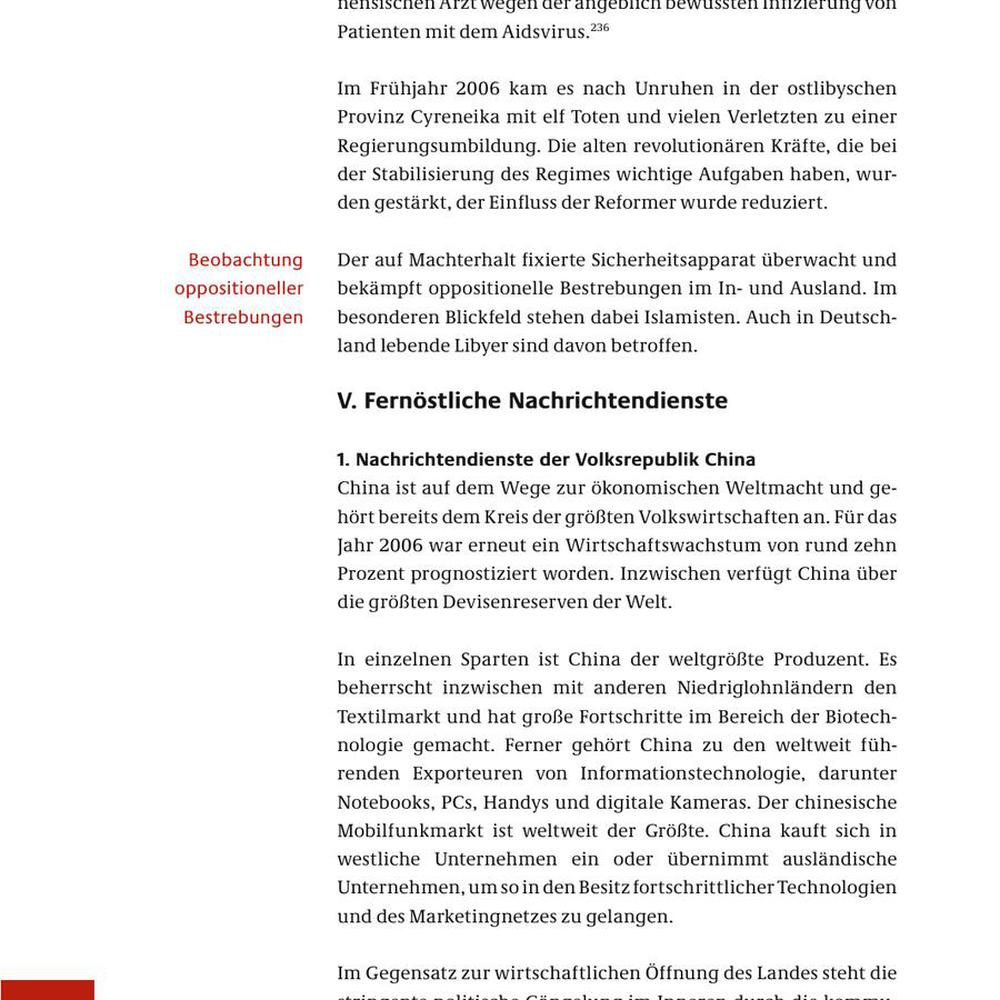

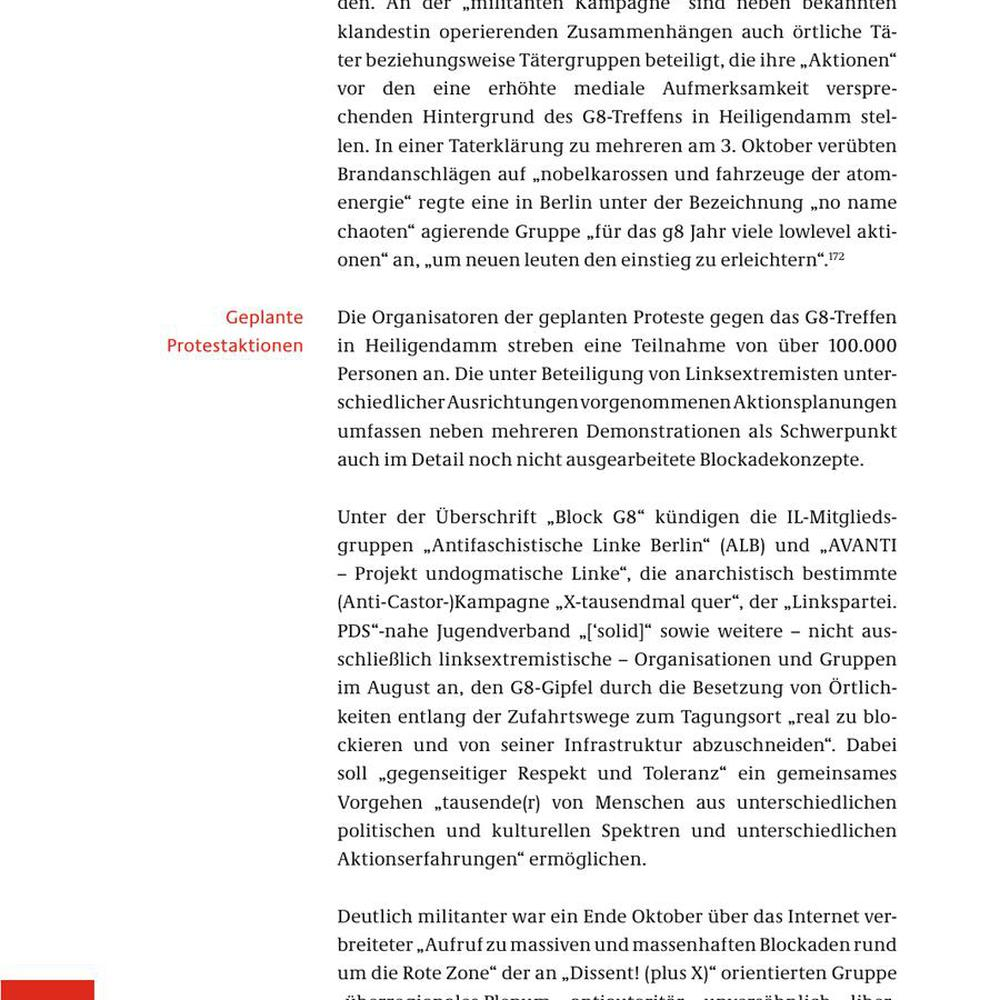

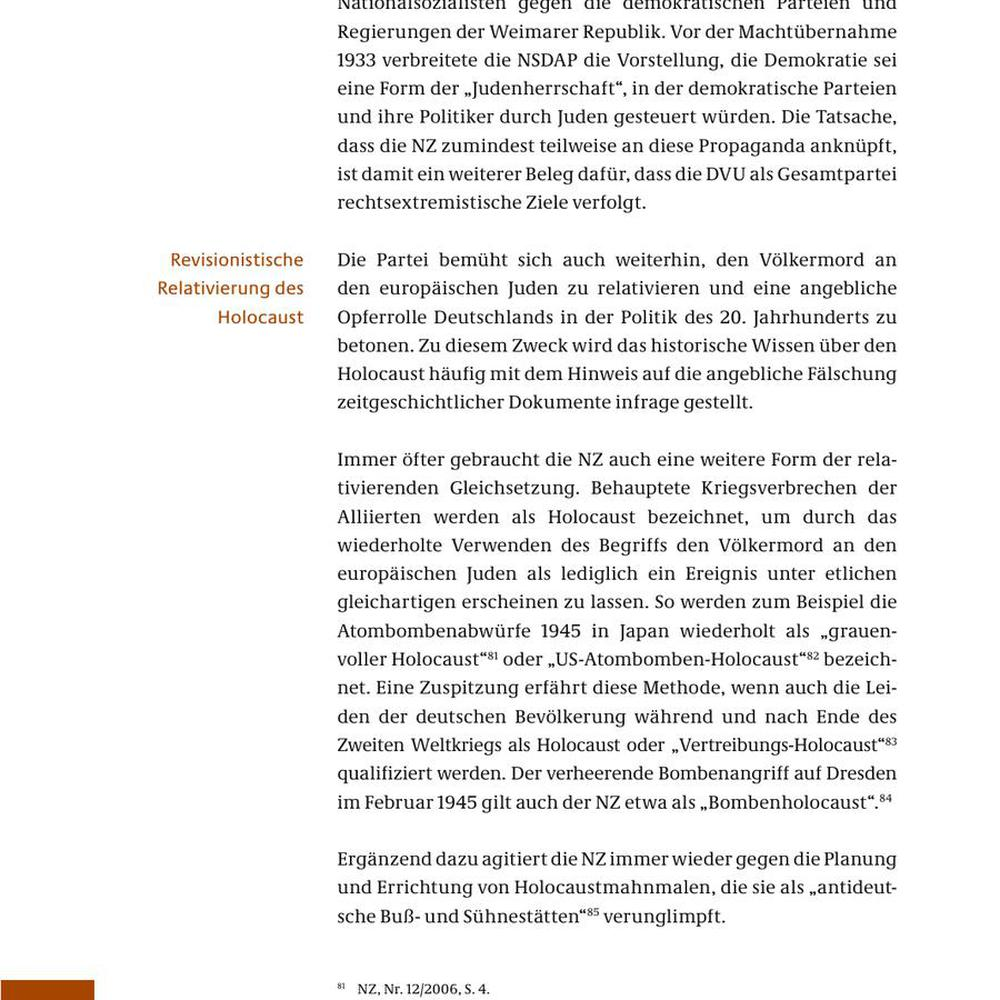

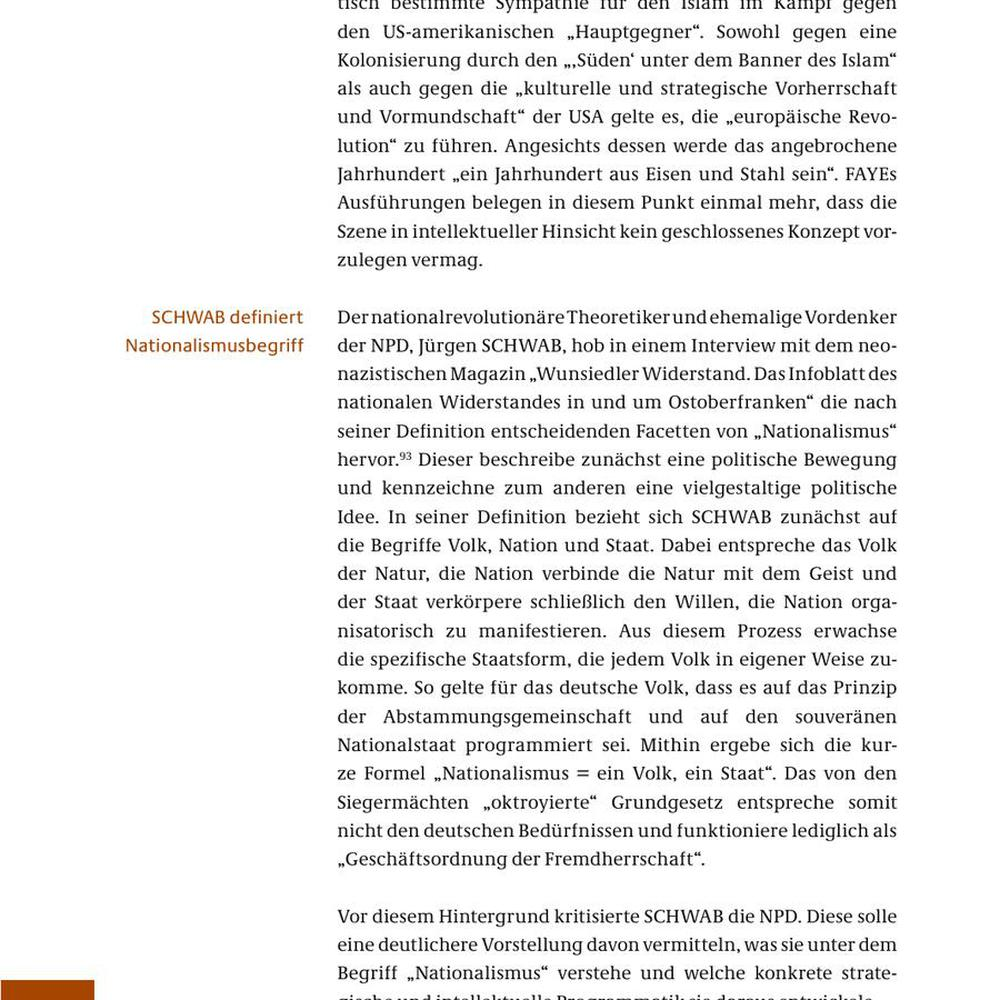

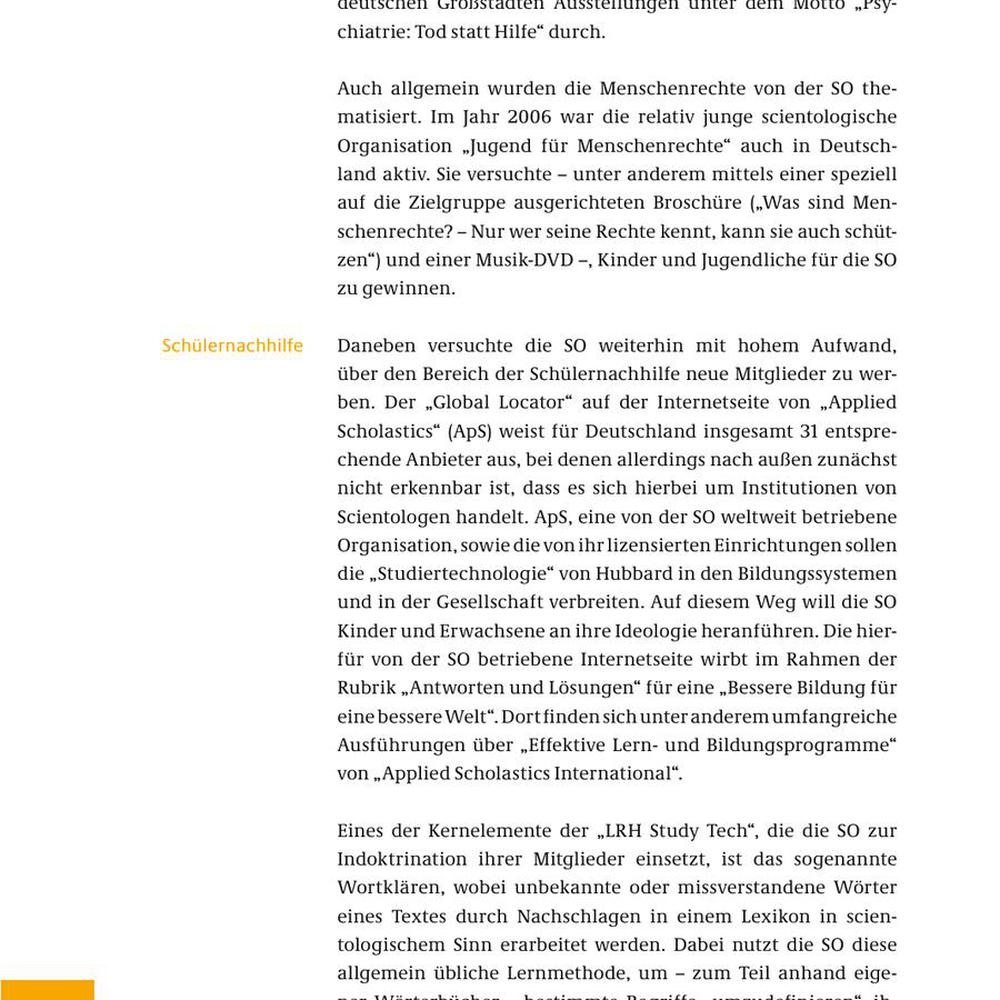

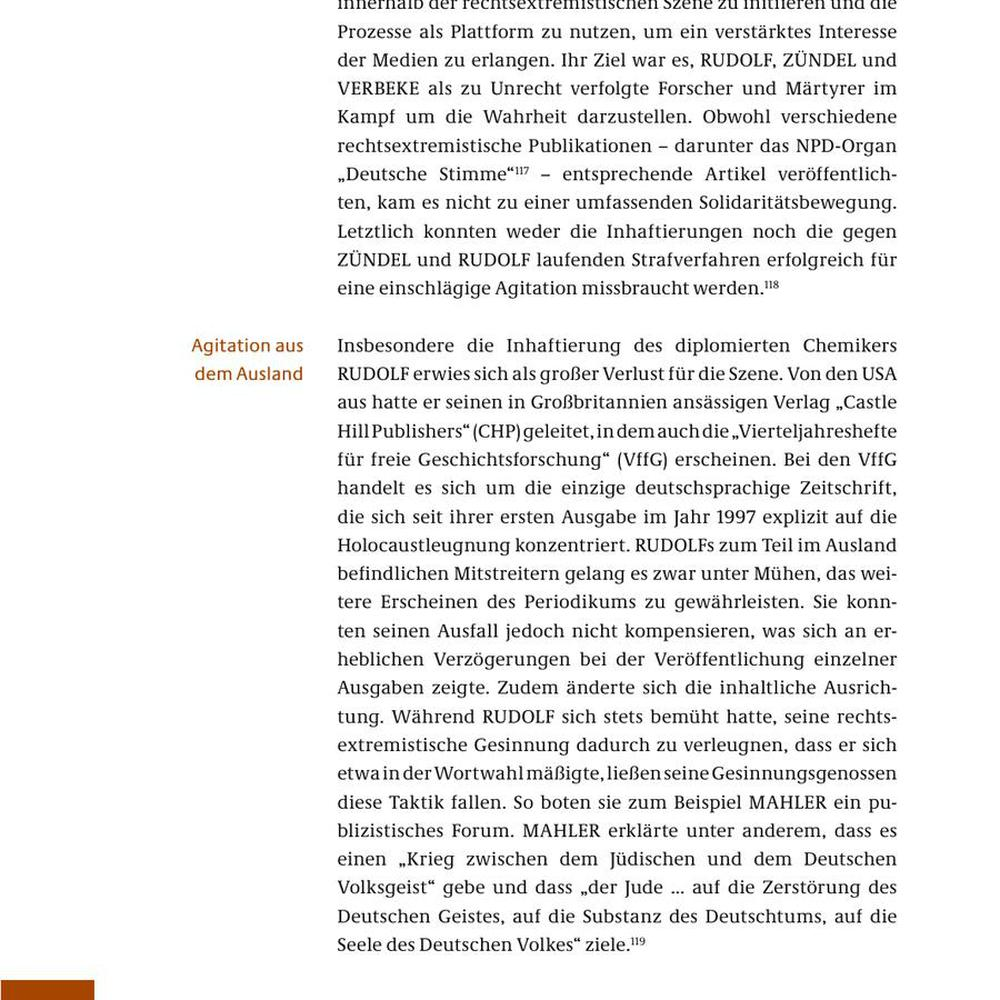

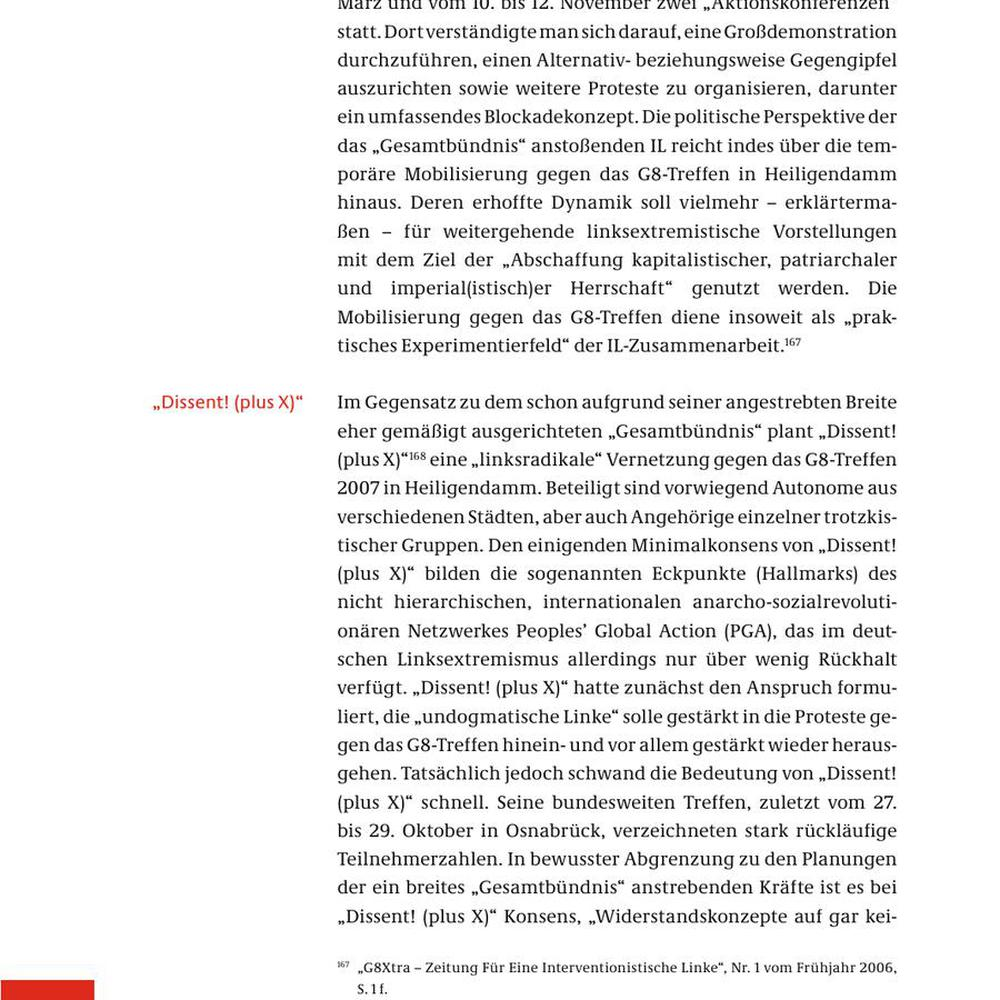

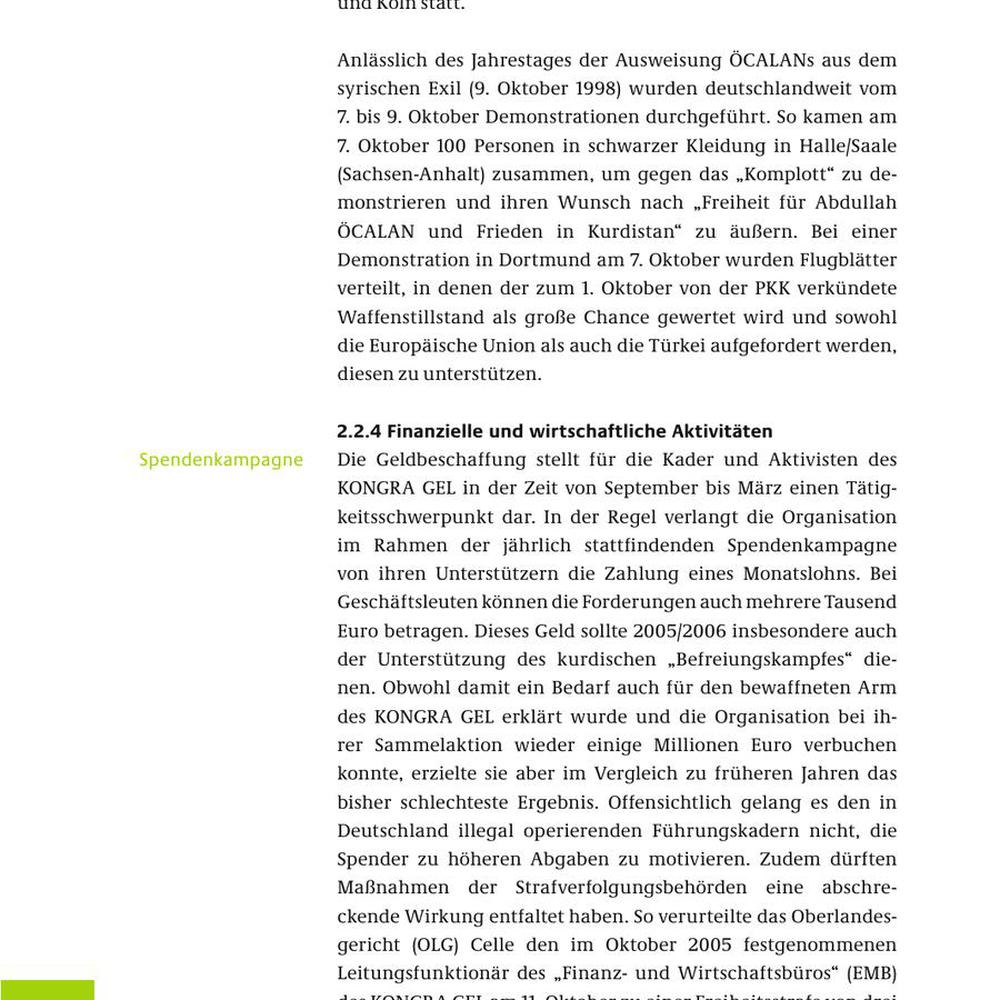

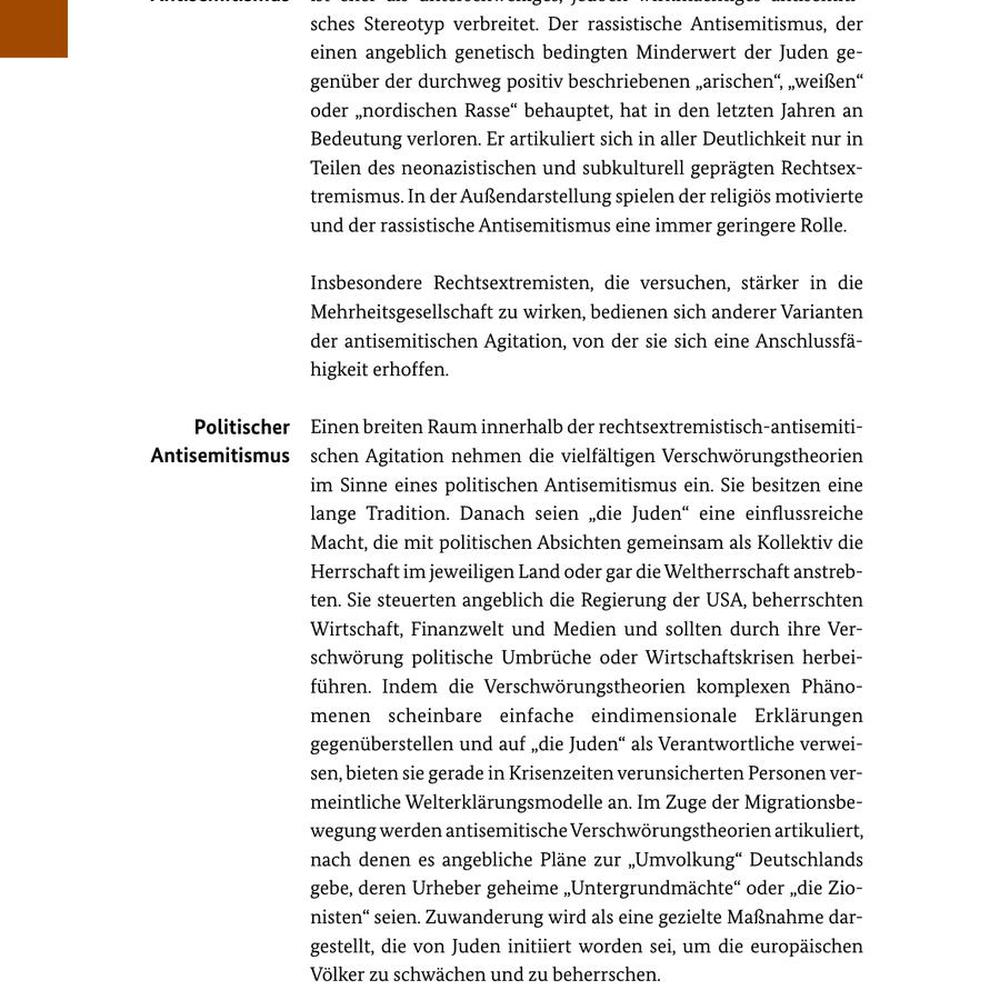

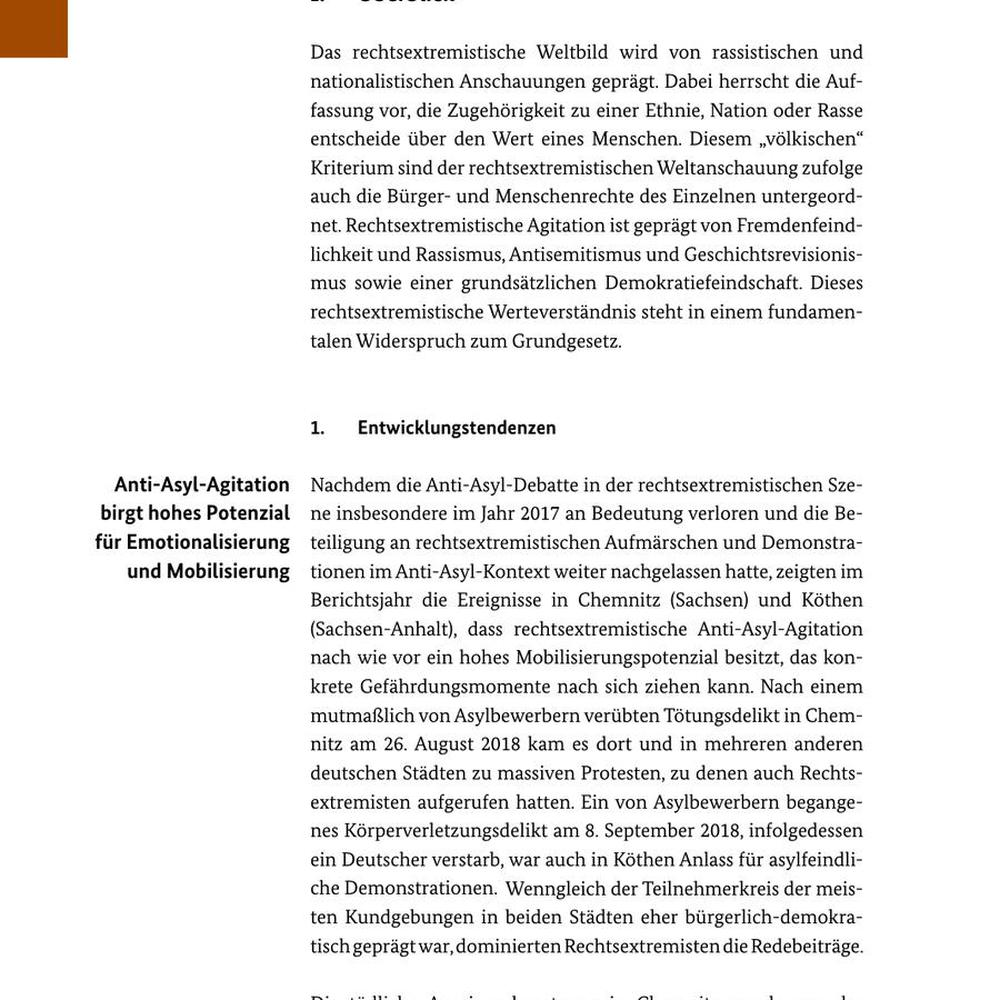

In [16]:
from IPython.display import Image, display
for i in o[:10]:
    display(Image(filename=f"/mnt/data2/vsb/imgs/{i}.jpg"))